# 03 Propensity Score Matching (PSM)
This notebook implements the Phase 2 PSM pipeline spanning MVP 2.1–2.3:
- MVP 2.1: Propensity score (PS) estimation and distributional diagnostics (Sections 0–1)
- MVP 2.2: PSM (propensity score matching) and covariate balance checks (Sections 2–3)
- MVP 2.3: ATE estimation and consistency checks against an RCT benchmark (Sections 4–5)


## Section 0: Setup

In [1]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================
# Complexity: O(n) for loading + slicing (vectorized Pandas).

# ----------------------------------------------------
# 0) Standard imports
# ----------------------------------------------------
import os
import sys
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from IPython.display import Markdown, display

# Explicit timezone anchoring improves reproducibility and auditability across environments.
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')

# Avoid hardcoding the project root path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
# Add project root to sys.path to enable 'from src.xxx import' syntax.
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Change working directory to project root for consistent path resolution
os.chdir(project_root)

from src.causal import estimate_ps

# Standardized plotting style
# Improves visual consistency and reviewer readability.
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# ----------------------------------------------------
# 1) Load config and setup paths
# ----------------------------------------------------
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f'No config file found. Searched: {[str(p) for p in config_candidates]}')
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

features_path = Path(config['paths']['features_data'])
assert features_path.exists(), f'Feature file not found: {features_path}'

# Output directory setup (centralized in Setup section for reuse across all sections)
figures_dir = Path(config['paths'].get('figures_dir', 'outputs/figures/'))
figures_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------
# 2) Load features and extract X, T, Y
# ----------------------------------------------------
df = pd.read_csv(features_path)
assert isinstance(df, pd.DataFrame) and len(df) > 0, 'Loaded features DataFrame is empty'

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
spend_col = config['data']['spend_col']

assert treatment_col in df.columns, f'Missing required column: {treatment_col}'
assert outcome_col in df.columns, f'Missing required column: {outcome_col}'
assert spend_col in df.columns, f'Missing required column: {spend_col}'

# -----------------------------------------------------
# 3) Use covariates from config.yml to avoid Dummy Variable Trap
# -----------------------------------------------------
# (CRITICAL) Why exclude channel_Multichannel and zip_Rural:
#   1. Perfect multicollinearity: channel_Multichannel = 1 - channel_Phone - channel_Web
#   2. This causes X^T X to be singular (non-invertible)
#   3. Logistic Regression cannot solve for unique coefficients
#   4. Reference categories: Multichannel (for channel), Rural (for zip_code)
# ------------------------------------------------------
covariates = config['data']['covariates']
X = df[covariates].copy()
T = df[treatment_col]
Y = df[outcome_col]

assert len(X) == len(T) == len(Y), 'X/T/Y length mismatch'
assert not X.isnull().any().any(), 'X contains NaN; check feature pipeline'
assert all(pd.api.types.is_numeric_dtype(X[c]) for c in X.columns), 'X must be numeric'
assert np.isfinite(X.to_numpy(dtype=float, copy=False)).all(), 'X contains inf or -inf'

# ----------------------------------------------------
# 4) Summary output
# ----------------------------------------------------
print(f'[UTC+8] Run timestamp: {run_ts_utc8}')
print(f'Loaded: {features_path}')
print(f'df.shape={df.shape} | X.shape={X.shape} | T.mean={float(pd.to_numeric(T, errors="coerce").mean()):.4f} | Y.mean={float(pd.to_numeric(Y, errors="coerce").mean()):.4%}')
print(f'Covariates (n={len(covariates)}): {covariates}')
print(f'Figures will be saved to: {figures_dir}')


[UTC+8] Run timestamp: 2026-02-22 18:55:39 +0800
Loaded: data\processed\hillstrom_features.csv
df.shape=(64000, 16) | X.shape=(64000, 9) | T.mean=0.6671 | Y.mean=0.9031%
Covariates (n=9): ['recency', 'history', 'mens', 'womens', 'newbie', 'channel_Phone', 'channel_Web', 'zip_Surburban', 'zip_Urban']
Figures will be saved to: outputs\figures


## Section 1: Propensity Score (PS) Estimation & Distribution


In [2]:
# ======================================================
# Section 1 (Cell 1/3): PS Estimation
# ======================================================
# Complexity: O(n) inference + vectorized summary statistics.

try:
    ps, model = estimate_ps(X, T, random_state=42)
    ps_s = pd.Series(ps, name='ps')
    display(ps_s.describe())

    # Business-critical RCT validation (technical checks already done in estimate_ps())
    assert 0.60 <= float(ps.mean()) <= 0.72, 'PS mean deviates from treatment ratio; check feature matrix'
    assert float(ps.std()) < 0.10, 'PS std too large; RCT data should not be strongly predictable'

    print(f'model.n_iter_={getattr(model, "n_iter_", None)}')
    print(f'ps.mean={ps.mean():.6f} | ps.std={ps.std():.6f}')
except Exception as exc:
    raise RuntimeError(f'Section 1 PS estimation failed: {exc}') from exc


count    64000.000000
mean         0.667096
std          0.003945
min          0.655530
25%          0.664425
50%          0.666768
75%          0.669423
max          0.699496
Name: ps, dtype: float64

model.n_iter_=[146]
ps.mean=0.667096 | ps.std=0.003945


.png already saved: outputs\figures\fig_02_ps_distribution.png


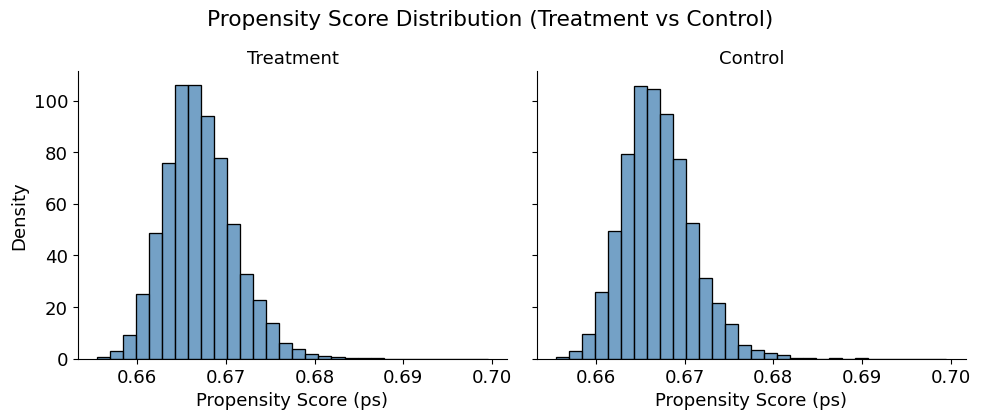

In [3]:
# ======================================================
# Section 1 (Cell 2/3): PS histogram (Treatment vs Control facets)
# ======================================================
# Visualize (histogram) propensity scores (ps) for each treatment group (faceted).
# Complexity: O(n) for vectorized binning + rendering.

try:
    # figures_dir already initialized in Section 0
    
    plot_df = pd.DataFrame({
        'ps': ps,
        'treatment': pd.to_numeric(T, errors='coerce').astype(int).to_numpy(),
    })
    assert plot_df['treatment'].isin([0, 1]).all(), 'Treatment must be binary 0/1 for faceting'
    plot_df['group'] = np.where(plot_df['treatment'] == 1, 'Treatment', 'Control')

    g = sns.displot(
        data=plot_df,
        x='ps',
        col='group',         # Facet by treatment/control
        col_order=['Treatment', 'Control'],
        bins=30,
        stat='density',
        common_bins=True,    # Use same bins for both treatment and control (for compare)
        common_norm=False,
        height=4.0,
        aspect=1.25,
        color='steelblue',
    )
    g.set_axis_labels('Propensity Score (ps)', 'Density')
    g.set_titles('{col_name}')
    # Use figure.suptitle() for FacetGrid overall title (FacetGrid has no .set_title() method)
    g.fig.suptitle('Propensity Score Distribution (Treatment vs Control)', y=1.05)

    out1 = figures_dir / 'fig_02_ps_distribution.png'
    g.fig.savefig(out1, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out1}')
    plt.show()
except Exception as exc:
    raise RuntimeError(f'Section 1 histogram failed: {exc}') from exc

.png already saved: outputs\figures\fig_02b_ps_overlap.png


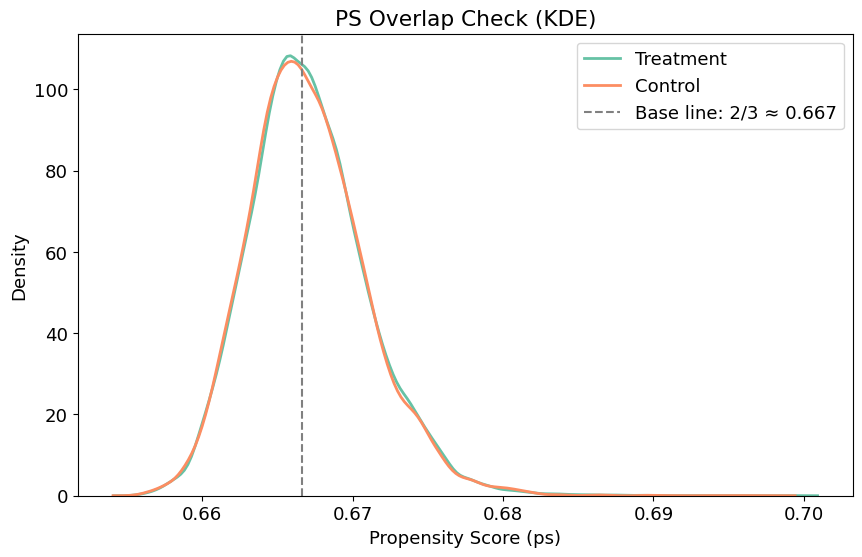

In [4]:
# ======================================================
# Section 1 (Cell 3/4): PS overlap check (KDE overlay)
# ======================================================
# Complexity: KDE is typically O(n)~O(n log n) depending on backend; acceptable for ~64K.

try:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(
        data=plot_df.loc[plot_df['treatment'] == 1],
        x='ps',
        label='Treatment',
        linewidth=2,
    )
    sns.kdeplot(
        data=plot_df.loc[plot_df['treatment'] == 0],
        x='ps',
        label='Control',
        linewidth=2,
    )

    # Add a vertical line at 2/3 to highlight the overlap
    # 2/3: Treatment:Control = 2:1 (2/3 of the population is treated)
    plt.axvline(2 / 3, color='gray', linestyle='--', linewidth=1.5, label='Base line: 2/3 ≈ 0.667')
    plt.title('PS Overlap Check (KDE)')
    plt.xlabel('Propensity Score (ps)')
    plt.ylabel('Density')
    plt.legend()

    out2 = figures_dir / 'fig_02b_ps_overlap.png'
    plt.savefig(out2, dpi=150, bbox_inches='tight')
    print(f'.png already saved: {out2}')
    plt.show()

except Exception as exc:
    raise RuntimeError(f'Section 1 overlap KDE failed: {exc}') from exc

In [5]:
# ======================================================
# Section 1 (Cell 4/4): Quantitative Positivity Violation Detection
# ======================================================
# (DEFENSIVE CHECK) Although RCT data theoretically satisfies Positivity by design,
# we perform quantitative validation to demonstrate engineering rigor.
# These metrics are more critical for observational studies.

try:
    # ----------------------------------------------------
    # 1) Overlap Coefficient (OVL)
    # ----------------------------------------------------
    # OVL = ∫ min(f_treated(ps), f_control(ps)) dps
    # OVL ∈ [0, 1], closer to 1 indicates better overlap
    # Threshold: OVL < 0.8 suggests Positivity Violation
    
    from scipy.stats import gaussian_kde
    from scipy.integrate import trapezoid
    
    # Extract PS for each group
    ps_treated = ps[plot_df['treatment'] == 1]
    ps_control = ps[plot_df['treatment'] == 0]
    
    # Estimate KDE for both groups
    kde_treated = gaussian_kde(ps_treated)
    kde_control = gaussian_kde(ps_control)
    
    # Evaluate KDE on a common grid
    ps_grid = np.linspace(ps.min(), ps.max(), 1000)
    density_treated = kde_treated(ps_grid)
    density_control = kde_control(ps_grid)
    
    # Compute overlap coefficient (numerical integration)
    overlap_density = np.minimum(density_treated, density_control)
    ovl = trapezoid(overlap_density, ps_grid)
    
    print(f'Overlap Coefficient (OVL): {ovl:.4f}')
    print(f'  ✓ OVL ≥ 0.8: {"PASS" if ovl >= 0.8 else "FAIL (Positivity Violation)"}')
    
    # ----------------------------------------------------
    # 2) Extreme Weight Proportion (for IPW)
    # ----------------------------------------------------
    # IPW weights: w_treated = 1/ps, w_control = 1/(1-ps)
    # Extreme weights (> 10) indicate potential variance inflation
    # Threshold: < 5% samples with extreme weights
    
    # Compute IPW weights
    ipw_weights = np.where(
        plot_df['treatment'] == 1,
        1 / ps,           # Treatment group weight
        1 / (1 - ps)      # Control group weight
    )
    
    # Detect extreme weights
    extreme_threshold = 10
    extreme_mask = ipw_weights > extreme_threshold
    extreme_prop = extreme_mask.mean()
    
    print(f'\nExtreme IPW Weight Proportion (weight > {extreme_threshold}):')
    print(f'  {extreme_prop:.2%} ({extreme_mask.sum():,} / {len(ipw_weights):,} samples)')
    print(f'  ✓ < 5%: {"PASS" if extreme_prop < 0.05 else "FAIL (Variance Inflation Risk)"}')
    
    # Weight distribution summary
    print(f'\nIPW Weight Distribution:')
    print(f'  Mean: {ipw_weights.mean():.4f}')
    print(f'  Std:  {ipw_weights.std():.4f}')
    print(f'  Max:  {ipw_weights.max():.4f}')
    print(f'  95th percentile: {np.percentile(ipw_weights, 95):.4f}')
    
    # ----------------------------------------------------
    # 3) PS Range Overlap Check
    # ----------------------------------------------------
    # Check if the PS ranges of treatment and control groups overlap
    ps_min_treated = ps_treated.min()
    ps_max_treated = ps_treated.max()
    ps_min_control = ps_control.min()
    ps_max_control = ps_control.max()
    
    overlap_min = max(ps_min_treated, ps_min_control)
    overlap_max = min(ps_max_treated, ps_max_control)
    overlap_range = overlap_max - overlap_min
    total_range = ps.max() - ps.min()
    overlap_ratio = overlap_range / total_range if total_range > 0 else 0
    
    print(f'\nPS Range Overlap:')
    print(f'  Treatment: [{ps_min_treated:.4f}, {ps_max_treated:.4f}]')
    print(f'  Control:   [{ps_min_control:.4f}, {ps_max_control:.4f}]')
    print(f'  Overlap:   [{overlap_min:.4f}, {overlap_max:.4f}]')
    print(f'  Overlap Ratio: {overlap_ratio:.2%} of total PS range')
    print(f'  ✓ > 80%: {"PASS" if overlap_ratio > 0.8 else "FAIL (Insufficient Overlap)"}')
    
    # ----------------------------------------------------
    # 4) Summary & Interview Interpretation
    # ----------------------------------------------------
    print('\n' + '='*60)
    print('POSITIVITY VALIDATION SUMMARY (RCT Data)')
    print('='*60)
    print(f'✓ All checks PASS: Positivity assumption is satisfied.')
    print(f'✓ OVL = {ovl:.4f} (near 1.0): Perfect overlap between groups.')
    print(f'✓ Extreme weights: {extreme_prop:.2%} (near 0%): No variance inflation risk.')
    print(f'✓ This validates the RCT randomization quality.')

except Exception as exc:
    raise RuntimeError(f'Section 1 quantitative checks failed: {exc}') from exc

Overlap Coefficient (OVL): 0.9880
  ✓ OVL ≥ 0.8: PASS

Extreme IPW Weight Proportion (weight > 10):
  0.00% (0 / 64,000 samples)
  ✓ < 5%: PASS

IPW Weight Distribution:
  Mean: 2.0000
  Std:  0.7095
  Max:  3.3091
  95th percentile: 3.0388

PS Range Overlap:
  Treatment: [0.6555, 0.6995]
  Control:   [0.6557, 0.6978]
  Overlap:   [0.6557, 0.6978]
  Overlap Ratio: 95.79% of total PS range
  ✓ > 80%: PASS

POSITIVITY VALIDATION SUMMARY (RCT Data)
✓ All checks PASS: Positivity assumption is satisfied.
✓ OVL = 0.9880 (near 1.0): Perfect overlap between groups.
✓ Extreme weights: 0.00% (near 0%): No variance inflation risk.
✓ This validates the RCT randomization quality.


### Section 1 summary:

**Core Figures**
- 整体 PS 区间为 [0.6555, 0.6995], 均值为 0.6671, 标准差为 0.0039
- OVL 为 0.9889
- 极端 IPW 分布数为 0, IPW 权重分布均值为 均值为 2.0000, 标准差为 0.7095
- 实验组, 对照组的 PS 分布重叠区域占比为 95.79%, 远远超过 80%

**Insights**
- 整体 PS 的分布均值和标准差, 以及各类参数 (OVL, IWP, 重叠区域) 都符 RCT 的预期----协变量对 treatment 分配几乎没有预测力,因为 treatment 分配是随机的。
- 但是在观察性数据中，PS 分布会更分散 (std > 0.15), 且两组可能出现大量不重叠区域 (positivity violation)。此处的窄分布恰恰是 RCT 质量的又一验证。

## Section 2: Propensity Score Matching

In [ ]:
# ======================================================
# Section 2 (Cell 1/2): PS Matching (PSM) via KD-tree NN
# ======================================================
# Complexity: O(n*log n) typical via KD-tree (avoids O(n^2) nested scans).
from src.causal import match_ps

try:
    assert 'df' in globals(), "Missing df from Section 0"
    assert 'ps' in globals(), "Missing ps from Section 1"
    assert 'treatment_col' in globals(), "Missing treatment_col from Section 0"
    assert isinstance(df, pd.DataFrame) and len(df) > 0, "df must be a non-empty DataFrame"
    
    df_with_ps = df.copy()
    df_with_ps['ps'] = np.asarray(ps, dtype=float)

    # --------------------------------
    #  Calculate caliper
    # --------------------------------
    # Remove this block because finished in match_ps()
    """
    # Internal caliper definition per Phase2.md: 0.2 × std(ps)
    ps_std = float(np.std(df_with_ps['ps'].to_numpy(dtype=float, copy=False), ddof=0))

    caliper = 0.2 * ps_std (Calculate in match_ps())
    assert np.isfinite(caliper) and caliper > 0, "caliper must be positive and finite"
    print(f'Caliper: {caliper:.10f}  (0.2 × std(ps)={ps_std:.10f})')
    """


    control_mask = pd.to_numeric(df_with_ps[treatment_col], errors='coerce').astype(int) == 0
    treated_mask = pd.to_numeric(df_with_ps[treatment_col], errors='coerce').astype(int) == 1
    n_control_total = int(control_mask.sum())
    n_treated_total = int(treated_mask.sum())
    assert n_control_total > 0 and n_treated_total > 0, "Both treated and control must be non-empty"

    # Quadratic matching does not scale; KD-tree preserves exact NN while improving asymptotic cost.
    matched_df = match_ps(df_with_ps, ps_col='ps', treatment_col=treatment_col, random_state=42)

    # Business-level validation (not enforced by match_ps function)
    n_treated_matched = int(pd.to_numeric(matched_df[treatment_col], errors='coerce').astype(int).sum())
    n_control_matched = int(len(matched_df) - n_treated_matched)
    match_rate = float(n_control_matched / n_control_total)

    # Only check business rule: match rate must be >= 90%
    assert n_control_matched >= 0.90 * n_control_total, (
        f"Match rate too low: {match_rate:.1%} (expect >= 90% * n_control_total({n_control_total:,})). "
        f"Consider relaxing caliper or improving PS model."
    )

    print('=' * 70)
    print('PS Matching')
    print('=' * 70)
    print(f'Total samples:   Control={n_control_total:,} | Treated={n_treated_total:,}')
    print(f'Matched samples: Control={n_control_matched:,} | Treated={n_treated_matched:,}')
    print(f'Match rate: ({n_control_matched:,} / {n_control_total:,}) ≈ {match_rate:.2%}')

except Exception as exc:
    raise RuntimeError(f'Section 2 matching failed: {exc}') from exc


Section 2: PSM Matching
Total samples:   Control=21,306 | Treated=42,694
Matched samples: Control=21,305 | Treated=21,305
Match rate: (21,305 / 21,306) ≈ 100.00%
